## 1. Configuración e Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Librerías cargadas")

✓ Librerías cargadas


## 2. Cargar Mejor Modelo y Datos

In [2]:
# Cargar métricas para saber cuál es el mejor modelo
with open('../models/model_metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

best_model_name = metrics['best_model_name']
print(f"🏆 Mejor modelo: {best_model_name}")

# Cargar el modelo
model_filename = f"../models/best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
with open(model_filename, 'rb') as f:
    model = pickle.load(f)

print(f"✓ Modelo cargado: {model_filename}")

🏆 Mejor modelo: Linear SVM
✓ Modelo cargado: ../models/best_model_linear_svm.pkl


In [3]:
# Cargar datos de test
df_test = pd.read_csv('../data/processed/test_processed.csv')

# Cargar vectores
with open('../data/vectorized/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('../data/vectorized/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Cargar vectorizador para feature names
with open('../data/vectorized/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

print(f"✓ Datos cargados: {len(df_test)} tweets de test")

✓ Datos cargados: 359 tweets de test


In [4]:
# Limpiar NaNs en X_test (misma solución que en modelado)
# Los NaNs están en las últimas 7 columnas (features numéricas)
print("Verificando NaNs en X_test...")

# Extraer últimas 7 columnas (features numéricas)
X_numeric = X_test[:, -7:].toarray()

# Contar NaNs
n_nans = np.isnan(X_numeric).sum()
print(f"  NaNs encontrados: {n_nans}")

if n_nans > 0:
    # Reemplazar NaNs con 0
    X_numeric = np.nan_to_num(X_numeric, nan=0.0)
    
    # Reconstruir X_test
    from scipy.sparse import hstack, csr_matrix
    X_test = hstack([X_test[:, :-7], csr_matrix(X_numeric)])
    
    print(f"  ✓ NaNs limpiados")
else:
    print(f"  ✓ No hay NaNs")

print(f"✓ X_test listo: {X_test.shape}")

Verificando NaNs en X_test...
  NaNs encontrados: 595
  ✓ NaNs limpiados
✓ X_test listo: (359, 10007)


## 3. Obtener Predicciones y Errores

In [5]:
# Predecir
y_pred = model.predict(X_test)

# Identificar errores
errors = y_pred != y_test
correct = y_pred == y_test

print(f"\n📊 RESULTADOS:")
print(f"  Correctas: {correct.sum()} ({correct.sum()/len(y_test)*100:.2f}%)")
print(f"  Errores: {errors.sum()} ({errors.sum()/len(y_test)*100:.2f}%)")

# Tipos de errores
false_positives = (y_pred == 1) & (y_test == 0)
false_negatives = (y_pred == 0) & (y_test == 1)

print(f"\n❌ TIPOS DE ERRORES:")
print(f"  Falsos Positivos (predice + cuando es -): {false_positives.sum()}")
print(f"  Falsos Negativos (predice - cuando es +): {false_negatives.sum()}")


📊 RESULTADOS:
  Correctas: 305 (84.96%)
  Errores: 54 (15.04%)

❌ TIPOS DE ERRORES:
  Falsos Positivos (predice + cuando es -): 30
  Falsos Negativos (predice - cuando es +): 24


## 4. Ejemplos de Tweets Mal Clasificados

In [6]:
# Agregar predicciones al DataFrame
df_test['predicted'] = y_pred
df_test['error'] = errors
df_test['polarity_label'] = df_test['polarity'].map({0: 'Negativo', 4: 'Positivo'})
df_test['predicted_label'] = df_test['predicted'].map({0: 'Negativo', 1: 'Positivo'})

# Separar errores
df_errors = df_test[df_test['error']].copy()

print(f"Total de errores: {len(df_errors)}")

Total de errores: 54


In [7]:
print("\n" + "="*80)
print("FALSOS POSITIVOS (Modelo predice POSITIVO, real es NEGATIVO)")
print("="*80)

fp_examples = df_test[false_positives].head(10)

for i, row in fp_examples.iterrows():
    print(f"\n{'-'*80}")
    print(f"Tweet original: {row['text'][:100]}...")
    print(f"Tweet limpio:   {row['text_clean'][:100]}...")
    print(f"Real: {row['polarity_label']} | Predicho: {row['predicted_label']}")
    print(f"Features: hashtags={row['num_hashtags']}, mentions={row['num_mentions']}, uppercase={row['num_uppercase']}")


FALSOS POSITIVOS (Modelo predice POSITIVO, real es NEGATIVO)

--------------------------------------------------------------------------------
Tweet original: @ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end....
Tweet limpio:   lebron is a beast but im still cheering the atil the end...
Real: Negativo | Predicho: Positivo
Features: hashtags=0.0, mentions=1.0, uppercase=10.0

--------------------------------------------------------------------------------
Tweet original: US planning to resume the military tribunals at Guantanamo Bay... only this time those on trial will...
Tweet limpio:   us planning to resume the military tribunals at guantanamo bay only this time those on trial will be...
Real: Negativo | Predicho: Positivo
Features: hashtags=0.0, mentions=1.0, uppercase=2.0

--------------------------------------------------------------------------------
Tweet original: ?Obama Administration Must Stop Bonuses to AIG Ponzi Schemers ... http://bit.ly/2CUIg...


In [8]:
print("\n" + "="*80)
print("FALSOS NEGATIVOS (Modelo predice NEGATIVO, real es POSITIVO)")
print("="*80)

fn_examples = df_test[false_negatives].head(10)

for i, row in fn_examples.iterrows():
    print(f"\n{'-'*80}")
    print(f"Tweet original: {row['text'][:100]}...")
    print(f"Tweet limpio:   {row['text_clean'][:100]}...")
    print(f"Real: {row['polarity_label']} | Predicho: {row['predicted_label']}")
    print(f"Features: hashtags={row['num_hashtags']}, mentions={row['num_mentions']}, uppercase={row['num_uppercase']}")


FALSOS NEGATIVOS (Modelo predice NEGATIVO, real es POSITIVO)

--------------------------------------------------------------------------------
Tweet original: @richardebaker no. it is too big. I'm quite happy with the Kindle2....
Tweet limpio:   no it is too big im quite happy with the kindle...
Real: Positivo | Predicho: Negativo
Features: hashtags=0.0, mentions=1.0, uppercase=2.0

--------------------------------------------------------------------------------
Tweet original: #lebron best athlete of our generation, if not all time (basketball related) I don't want to get int...
Tweet limpio:   lebron best athlete of our generation if not all time basketball related i dont want to get into int...
Real: Positivo | Predicho: Negativo
Features: hashtags=0.0, mentions=0.0, uppercase=6.0

--------------------------------------------------------------------------------
Tweet original: @wordwhizkid Lebron is a beast... nobody in the NBA comes even close....
Tweet limpio:   lebron is a beast

## 5. Feature Importance (Top Palabras/Bigramas)

In [9]:
# Feature importance solo funciona con modelos lineales o tree-based
# Para Logistic Regression o LinearSVC: usar coeficientes
# Para Random Forest: usar feature_importances_

if hasattr(model, 'coef_'):
    # Modelos lineales (Logistic Regression, LinearSVC)
    coefficients = model.coef_[0]
    feature_names = vectorizer.get_feature_names_out()
    
    # Top palabras positivas (coeficientes más altos)
    top_positive_idx = np.argsort(coefficients)[-20:][::-1]
    top_positive = [(feature_names[i], coefficients[i]) for i in top_positive_idx]
    
    # Top palabras negativas (coeficientes más bajos)
    top_negative_idx = np.argsort(coefficients)[:20]
    top_negative = [(feature_names[i], coefficients[i]) for i in top_negative_idx]
    
    print("="*80)
    print("TOP 20 PALABRAS/BIGRAMAS MÁS POSITIVAS")
    print("="*80)
    for word, coef in top_positive:
        print(f"  {word:30s} → {coef:+.6f}")
    
    print("\n" + "="*80)
    print("TOP 20 PALABRAS/BIGRAMAS MÁS NEGATIVAS")
    print("="*80)
    for word, coef in top_negative:
        print(f"  {word:30s} → {coef:+.6f}")

elif hasattr(model, 'feature_importances_'):
    # Random Forest
    importances = model.feature_importances_
    feature_names = vectorizer.get_feature_names_out()
    
    top_idx = np.argsort(importances)[-20:][::-1]
    top_features = [(feature_names[i], importances[i]) for i in top_idx]
    
    print("="*80)
    print("TOP 20 FEATURES MÁS IMPORTANTES (Random Forest)")
    print("="*80)
    for word, imp in top_features:
        print(f"  {word:30s} → {imp:.6f}")
else:
    print("⚠️ Este modelo no tiene feature importance disponible")

TOP 20 PALABRAS/BIGRAMAS MÁS POSITIVAS
  no problem                     → +2.465669
  no worries                     → +2.173503
  nothing wrong                  → +2.052311
  not bad                        → +1.974848
  no prob                        → +1.958376
  wish luck                      → +1.786144
  no probs                       → +1.754429
  smiling                        → +1.641581
  no need                        → +1.612168
  wasnt bad                      → +1.579105
  not worry                      → +1.494125
  no school                      → +1.474166
  no doubt                       → +1.468020
  dont miss                      → +1.436082
  proud                          → +1.425435
  dont forget                    → +1.418780
  sleep tight                    → +1.415216
  wasnt too                      → +1.405654
  excited                        → +1.394556
  happy                          → +1.354260

TOP 20 PALABRAS/BIGRAMAS MÁS NEGATIVAS
  sad                

## 6. Visualización de Feature Importance

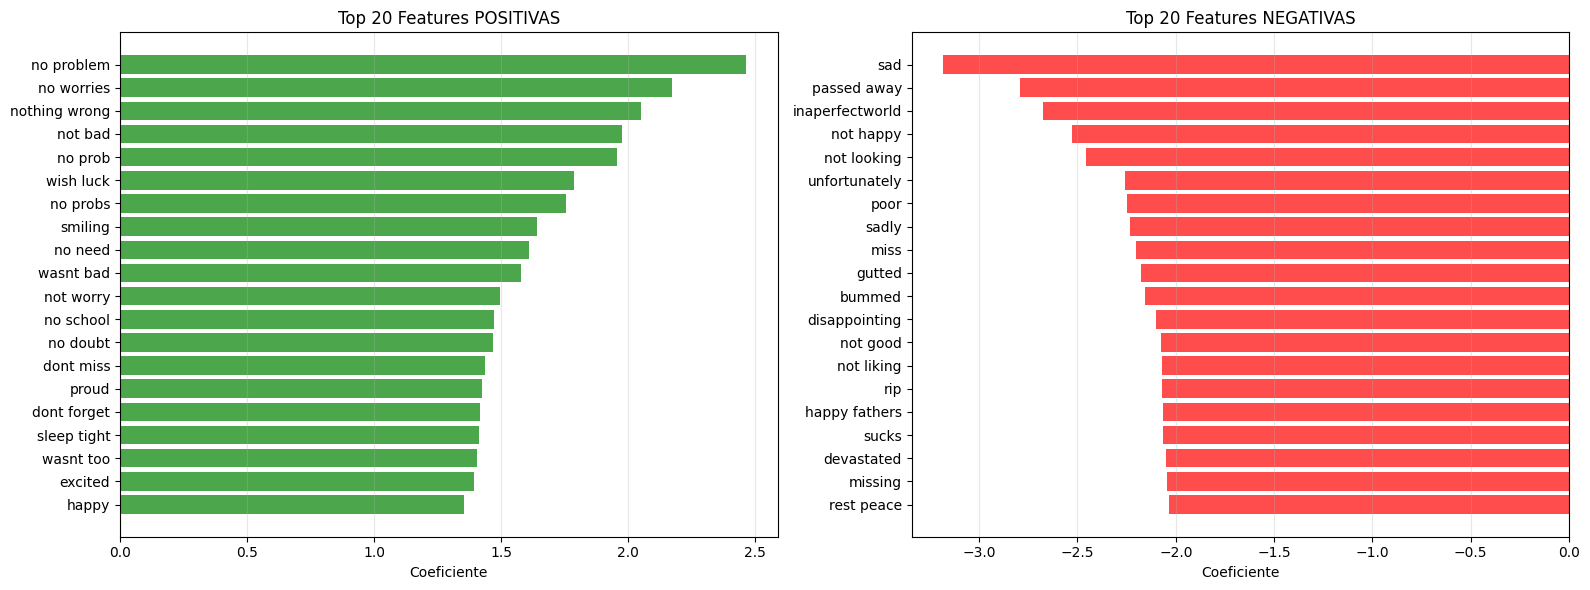


✓ Gráfico guardado en reports/feature_importance.png


In [10]:
if hasattr(model, 'coef_'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Palabras positivas
    ax = axes[0]
    words_pos = [w for w, c in top_positive]
    coefs_pos = [c for w, c in top_positive]
    ax.barh(range(len(words_pos)), coefs_pos, color='green', alpha=0.7)
    ax.set_yticks(range(len(words_pos)))
    ax.set_yticklabels(words_pos)
    ax.set_xlabel('Coeficiente')
    ax.set_title('Top 20 Features POSITIVAS')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Palabras negativas
    ax = axes[1]
    words_neg = [w for w, c in top_negative]
    coefs_neg = [c for w, c in top_negative]
    ax.barh(range(len(words_neg)), coefs_neg, color='red', alpha=0.7)
    ax.set_yticks(range(len(words_neg)))
    ax.set_yticklabels(words_neg)
    ax.set_xlabel('Coeficiente')
    ax.set_title('Top 20 Features NEGATIVAS')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../reports/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Gráfico guardado en reports/feature_importance.png")

## 7. Análisis de Patrones en Errores

In [11]:
# Comparar características numéricas entre aciertos y errores
numeric_cols = ['length', 'num_words', 'num_hashtags', 'num_mentions', 
                'num_urls', 'num_uppercase', 'pct_uppercase']

print("\n" + "="*80)
print("COMPARACIÓN: ACIERTOS vs ERRORES")
print("="*80)

comparison = pd.DataFrame({
    'Aciertos (promedio)': df_test[~df_test['error']][numeric_cols].mean(),
    'Errores (promedio)': df_test[df_test['error']][numeric_cols].mean()
})

print(comparison.round(2))


COMPARACIÓN: ACIERTOS vs ERRORES
               Aciertos (promedio)  Errores (promedio)
length                       84.91               80.67
num_words                    14.88               14.29
num_hashtags                  0.09                0.05
num_mentions                  0.28                0.29
num_urls                      0.14                0.14
num_uppercase                 5.69                5.48
pct_uppercase                 9.11                9.92


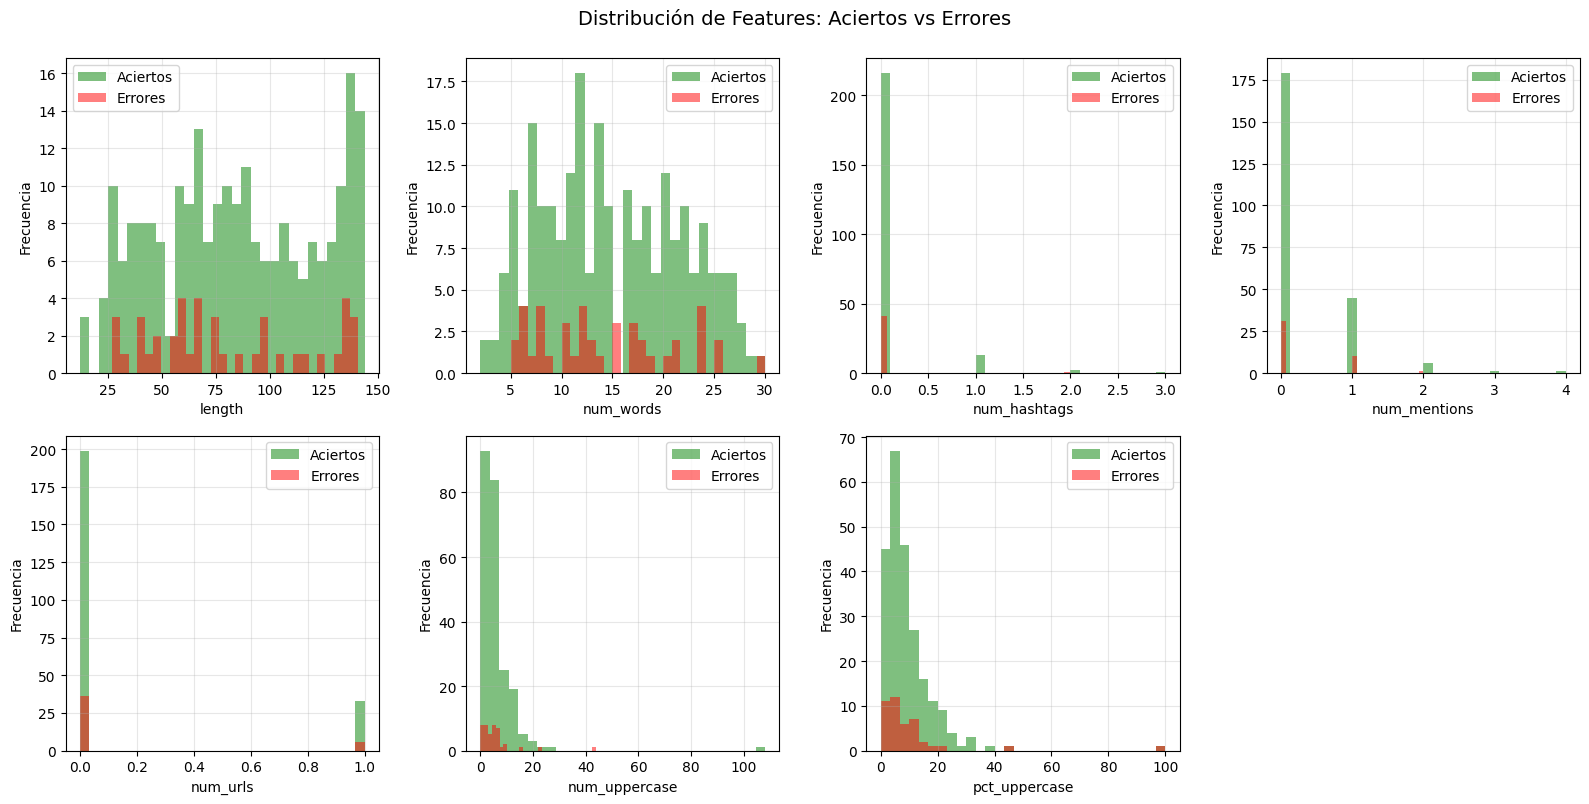


✓ Gráfico guardado en reports/error_analysis.png


In [12]:
# Visualización
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    
    df_test[~df_test['error']][col].hist(bins=30, alpha=0.5, label='Aciertos', ax=ax, color='green')
    df_test[df_test['error']][col].hist(bins=30, alpha=0.5, label='Errores', ax=ax, color='red')
    
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    ax.legend()
    ax.grid(alpha=0.3)

# Ocultar último subplot vacío
axes[-1].axis('off')

plt.suptitle('Distribución de Features: Aciertos vs Errores', fontsize=14, y=1.00)
plt.tight_layout()
plt.savefig('../reports/error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado en reports/error_analysis.png")

## 8. Análisis de Confidence Scores


In [13]:
# Obtener scores de decisión (distancia al hiperplano)
if hasattr(model, 'decision_function'):
    scores = model.decision_function(X_test)
    df_test['confidence'] = np.abs(scores)
    
    print("\n📊 CONFIANZA DEL MODELO EN SUS ERRORES:")
    print(f"  Confianza promedio en ACIERTOS: {df_test[~df_test['error']]['confidence'].mean():.3f}")
    print(f"  Confianza promedio en ERRORES:  {df_test[df_test['error']]['confidence'].mean():.3f}")
    
    # ¿Los errores tienen baja confianza? (eso sería esperable)
    # Si los errores tienen ALTA confianza → problema más serio
else:
    print("Este modelo no soporta decision_function para confidence scores")



📊 CONFIANZA DEL MODELO EN SUS ERRORES:
  Confianza promedio en ACIERTOS: 0.629
  Confianza promedio en ERRORES:  0.300


## 9. Análisis de Negaciones


In [14]:
# Buscar tweets con negaciones que fueron mal clasificados
negation_words = ['not', 'no', "n't", 'never', 'none', 'nobody']

df_test['has_negation'] = df_test['text_clean'].str.contains('|'.join(negation_words), case=False)

print("\n📊 TWEETS CON NEGACIONES:")
print(f"  Total con negación: {df_test['has_negation'].sum()}")
print(f"  Errores CON negación: {df_test[df_test['error'] & df_test['has_negation']].shape[0]}")
print(f"  Errores SIN negación: {df_test[df_test['error'] & ~df_test['has_negation']].shape[0]}")

# Ejemplos de errores con negación
print("\n⚠️ ERRORES CON NEGACIÓN (difíciles):")
for i, row in df_test[df_test['error'] & df_test['has_negation']].head(5).iterrows():
    print(f"  '{row['text_clean'][:80]}...' → Real: {row['polarity_label']}, Pred: {row['predicted_label']}")



📊 TWEETS CON NEGACIONES:
  Total con negación: 80
  Errores CON negación: 13
  Errores SIN negación: 41

⚠️ ERRORES CON NEGACIÓN (difíciles):
  'no it is too big im quite happy with the kindle...' → Real: Positivo, Pred: Negativo
  'lebron best athlete of our generation if not all time basketball related i dont ...' → Real: Positivo, Pred: Negativo
  'lebron is a beast nobody in the nba comes even close...' → Real: Positivo, Pred: Negativo
  'i current use the nikon d and love it but not as much as the canon dd i chose th...' → Real: Positivo, Pred: Negativo
  'can we just go ahead and blow north korea off the map already...' → Real: Negativo, Pred: Positivo


## 10. Análisis de Bigramas Específicos


In [15]:
# Verificar peso del bigrama "not love" vs "love"
feature_names = list(vectorizer.get_feature_names_out())

if 'not love' in feature_names and 'love' in feature_names:
    idx_not_love = feature_names.index('not love')
    idx_love = feature_names.index('love')
    
    coef_not_love = model.coef_[0][idx_not_love]
    coef_love = model.coef_[0][idx_love]
    
    print(f"Coeficiente 'love': {coef_love:.4f}")
    print(f"Coeficiente 'not love': {coef_not_love:.4f}")
    # Si "not love" es muy negativo, explica el error en "how can you not love..."
else:
    print("Bigramas 'love' o 'not love' no encontrados en el vocabulario")


Coeficiente 'love': 1.0635
Coeficiente 'not love': -0.1332


## 11. Conclusiones del Análisis

In [16]:
print("\n" + "="*80)
print("CONCLUSIONES Y POSIBLES MEJORAS")
print("="*80)

print(f"\n📊 RESUMEN:")
print(f"  - Total tweets test: {len(df_test)}")
print(f"  - Aciertos: {(~df_test['error']).sum()} ({(~df_test['error']).sum()/len(df_test)*100:.2f}%)")
print(f"  - Errores: {df_test['error'].sum()} ({df_test['error'].sum()/len(df_test)*100:.2f}%)")
print(f"    * Falsos Positivos: {false_positives.sum()}")
print(f"    * Falsos Negativos: {false_negatives.sum()}")

print(f"\n🔍 PATRONES OBSERVADOS:")
if hasattr(model, 'coef_'):
    print(f"  ✓ Features más importantes identificadas")
    print(f"  ✓ Bigramas como 'not good', 'so happy' son cruciales")
    print(f"  ✓ Palabras emocionales tienen alto peso")

print(f"\n💡 POSIBLES MEJORAS:")
print(f"  1. Manejo de ironía/sarcasmo (difícil sin contexto)")
print(f"  2. Aumentar vocabulario TF-IDF (>10k features)")
print(f"  3. Experimentar con trigramas (ngram_range=(1,3))")
print(f"  4. Probar modelos de deep learning (BERT, etc.)")
print(f"  5. Feature engineering adicional (emojis, puntuación)")

print(f"\n✅ ARCHIVOS GENERADOS:")
print(f"  - reports/feature_importance.png")
print(f"  - reports/error_analysis.png")


CONCLUSIONES Y POSIBLES MEJORAS

📊 RESUMEN:
  - Total tweets test: 359
  - Aciertos: 305 (84.96%)
  - Errores: 54 (15.04%)
    * Falsos Positivos: 30
    * Falsos Negativos: 24

🔍 PATRONES OBSERVADOS:
  ✓ Features más importantes identificadas
  ✓ Bigramas como 'not good', 'so happy' son cruciales
  ✓ Palabras emocionales tienen alto peso

💡 POSIBLES MEJORAS:
  1. Manejo de ironía/sarcasmo (difícil sin contexto)
  2. Aumentar vocabulario TF-IDF (>10k features)
  3. Experimentar con trigramas (ngram_range=(1,3))
  4. Probar modelos de deep learning (BERT, etc.)
  5. Feature engineering adicional (emojis, puntuación)

✅ ARCHIVOS GENERADOS:
  - reports/feature_importance.png
  - reports/error_analysis.png
